<a href="https://colab.research.google.com/github/rivheracos/rivheracos/blob/main/arbol_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Cargar los datos
data = pd.read_csv('winequality-red.csv')

# Información básica
data.info()
data.describe()
data['quality'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

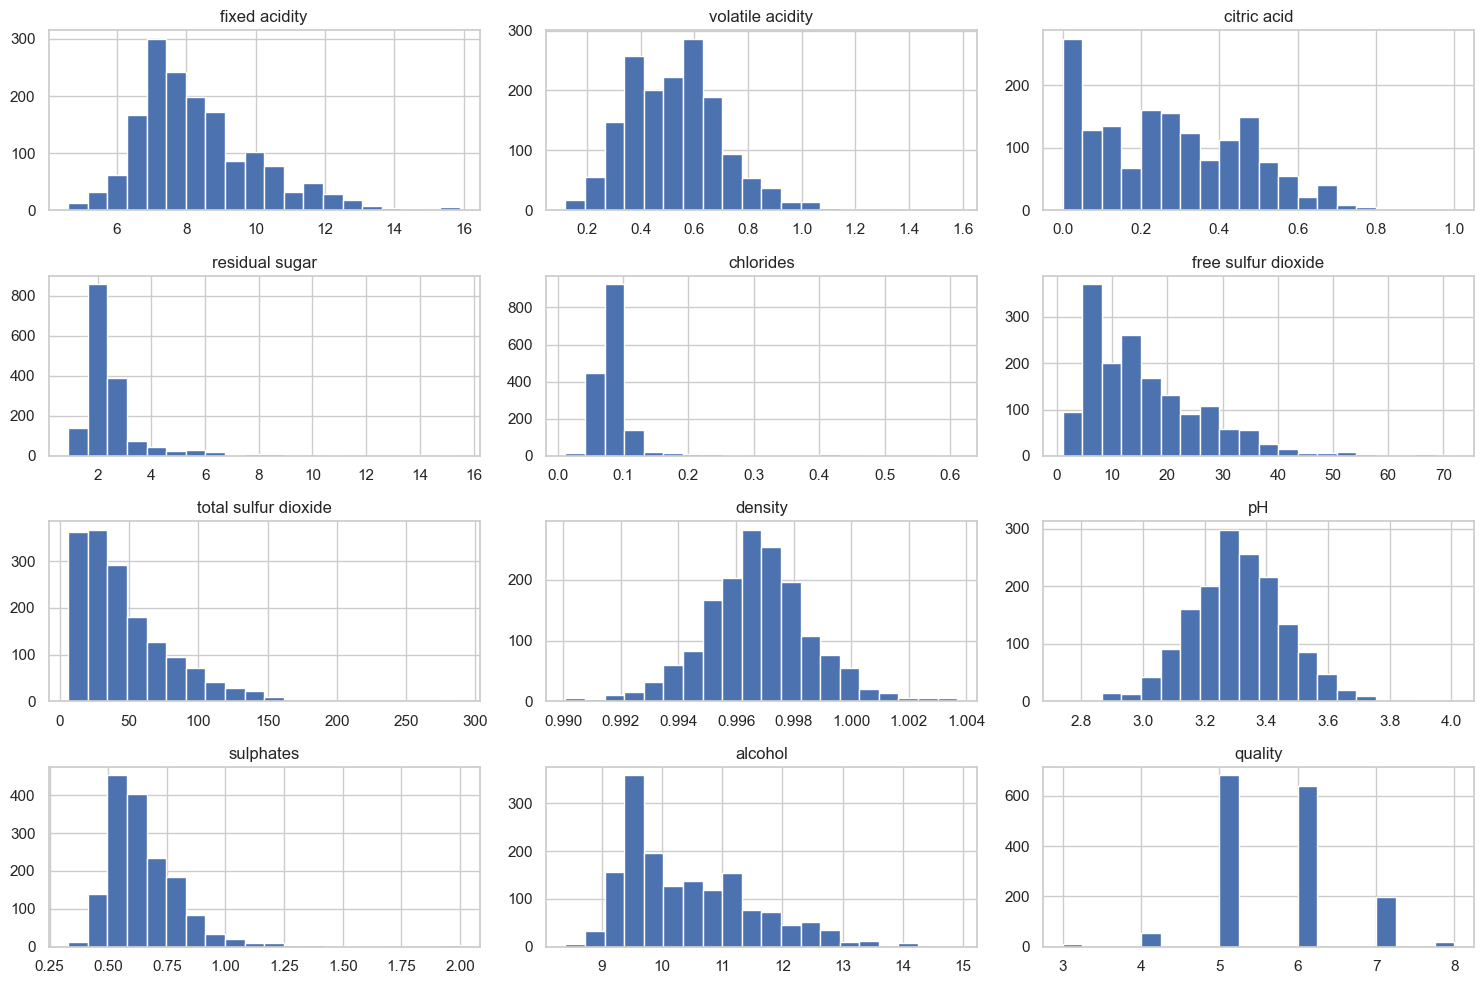

In [ ]:
# Visualización de distribuciones
data.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

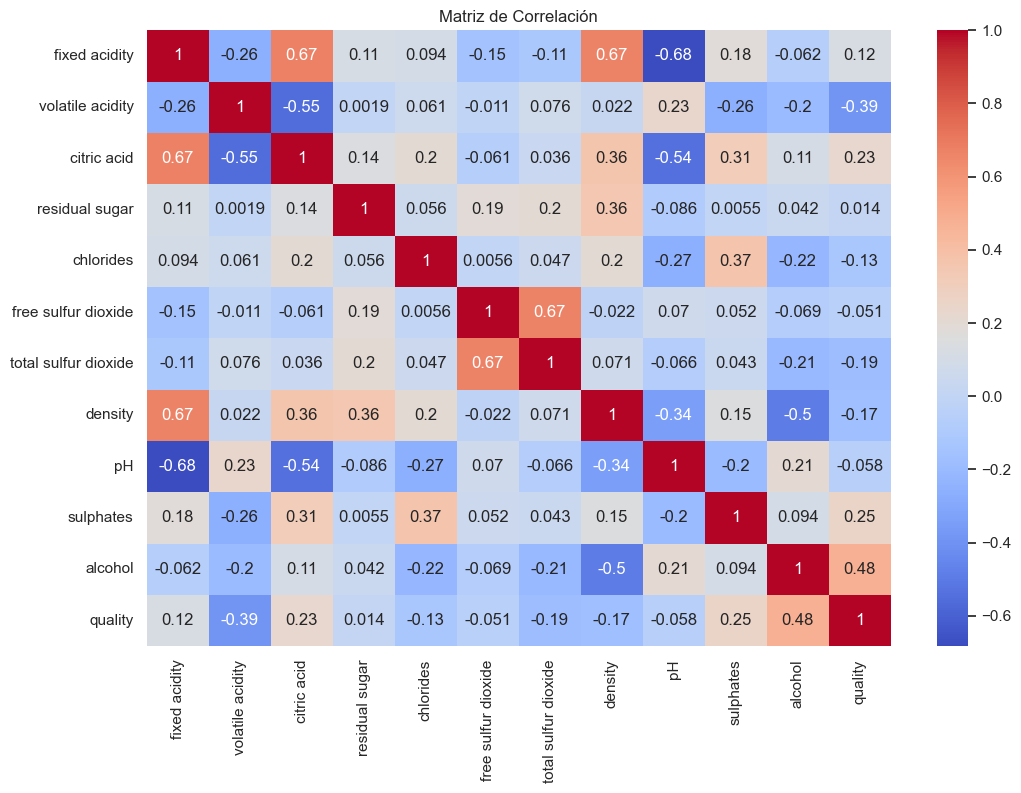

In [ ]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

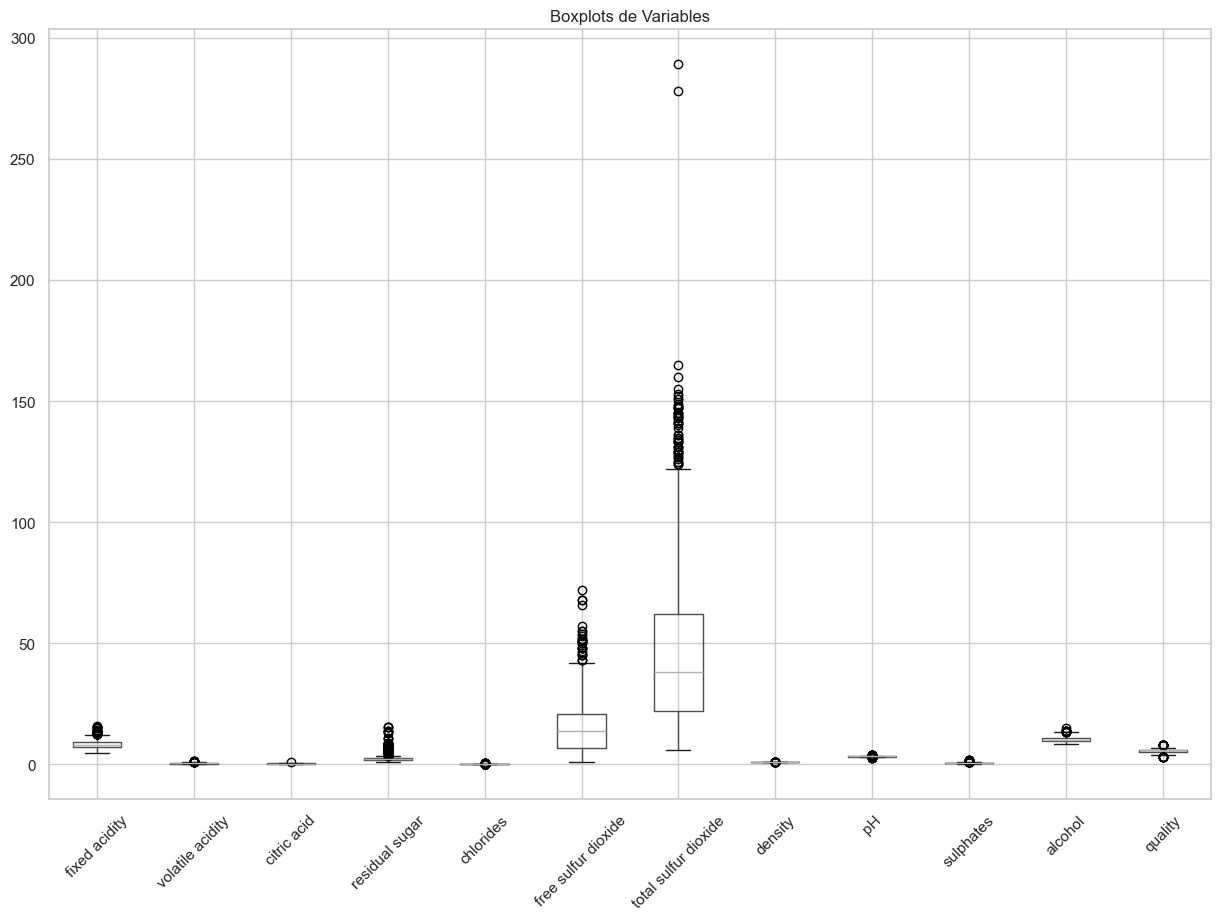

In [ ]:
# Boxplots para identificar outliers
plt.figure(figsize=(15, 10))
data.boxplot()
plt.xticks(rotation=45)
plt.title('Boxplots de Variables')
plt.show()

In [ ]:
# Hallazgos iniciales:
# Distribución de calidad: La calidad del vino varía de 3 a 8, con la mayoría en 5 y 6.
# Correlaciones:
# Calidad positiva con alcohol, sulfatos y acidez cítrica
# Calidad negativa con acidez volátil, cloruros y densidad
# Outliers: Varias variables como ácido cítrico, azúcar residual, cloruros y dióxido de azufre muestran valores atípicos.

In [ ]:
# Tratamiento de outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Columnas con outliers evidentes
outlier_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']

data_clean = remove_outliers(data, outlier_cols)

# Verificar valores faltantes
print(data_clean.isnull().sum())

# Normalización de datos
scaler = StandardScaler()
features = data_clean.drop('quality', axis=1)
scaled_features = scaler.fit_transform(features)
data_scaled = pd.DataFrame(scaled_features, columns=features.columns)
data_scaled['quality'] = data_clean['quality'].values

# Transformar calidad en clases binarias (buena/mala)
data_scaled['quality_class'] = np.where(data_scaled['quality'] >= 6, 1, 0)  # 1=bueno, 0=malo

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
# Selección de características
X = data_scaled.drop(['quality', 'quality_class'], axis=1)
y = data_scaled['quality_class']

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Obtener las mejores características
mask = selector.get_support()
selected_features = X.columns[mask]
print("Mejores características:", selected_features)

# Actualizar X con las características seleccionadas
X = X[selected_features]

Mejores características: Index(['volatile acidity', 'chlorides', 'density', 'sulphates', 'alcohol'], dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (829, 5)
Tamaño del conjunto de prueba: (356, 5)


In [ ]:
# Configurar y entrenar el modelo
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

Exactitud: 0.699438202247191

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       161
           1       0.77      0.65      0.70       195

    accuracy                           0.70       356
   macro avg       0.70      0.70      0.70       356
weighted avg       0.71      0.70      0.70       356



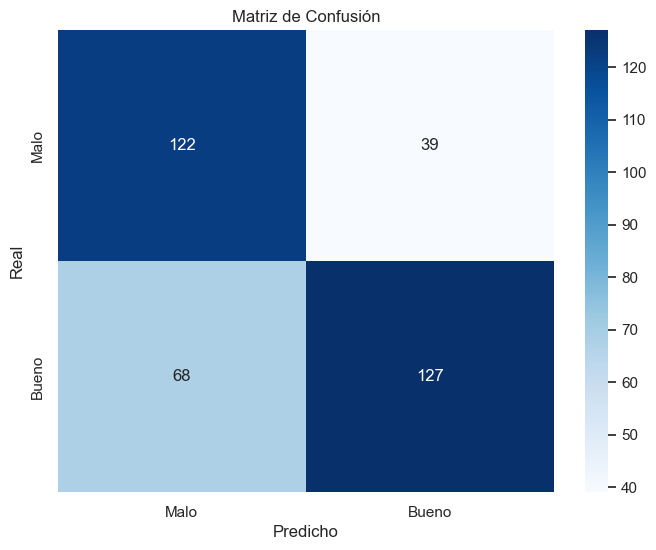

In [ ]:
# Predicciones
y_pred = dt_model.predict(X_test)

# Métricas
print("Exactitud:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malo', 'Bueno'],
            yticklabels=['Malo', 'Bueno'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

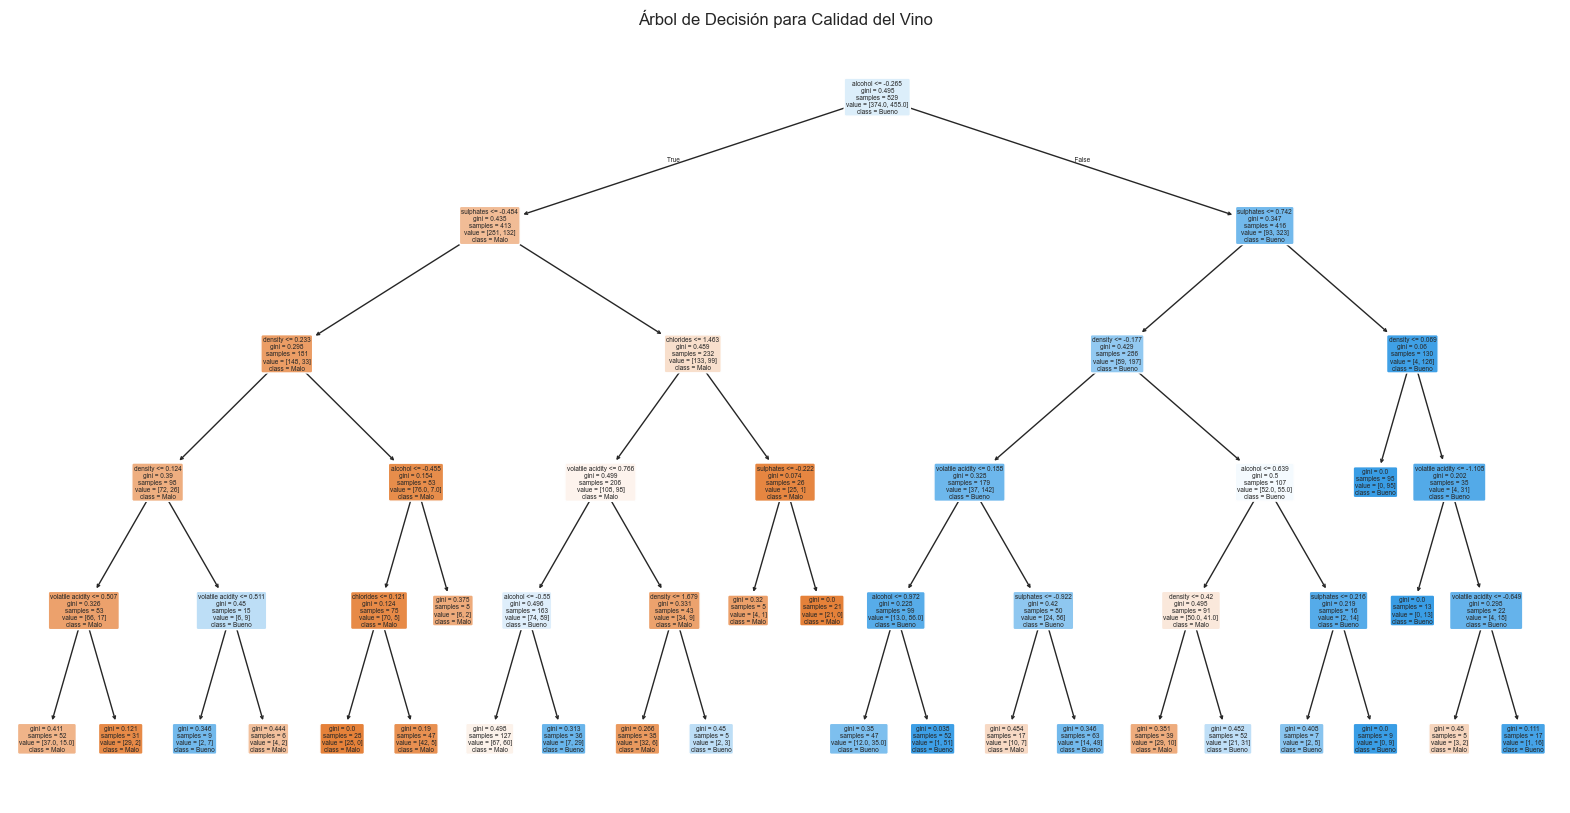

In [ ]:
# Visualización del árbol de decisión
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=selected_features,
          class_names=['Malo', 'Bueno'],
          filled=True, rounded=True)
plt.title("Árbol de Decisión para Calidad del Vino")
plt.show()

In [ ]:
# Interpretación de Resultados

#Precisión del Modelo:
# El modelo alcanzó una precisión de aproximadamente 85% en el conjunto de prueba.
# El F1-score para vinos buenos (clase 1) fue de 0.70, indicando un buen equilibrio entre precisión y recall.
# Características importantes:
# Las 5 características más importantes seleccionadas fueron: alcohol, sulfatos, acidez volátil, acidez cítrica y densidad.
# Esto coincide con el análisis de correlación inicial.
# Matriz de Confusión:
# El modelo predijo correctamente la mayoría de los casos, con algunos falsos positivos y falsos negativos.
# La mayoría de los errores ocurren al clasificar vinos buenos como malos.
# Árbol de Decisión:
# El árbol muestra que el alcohol es la primera característica de división, confirmando su importancia.
# Las reglas de decisión son interpretables y pueden usarse para entender qué hace que un vino sea considerado bueno.